<a href="https://colab.research.google.com/github/Likith55/11/blob/main/AIML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Install packages that may not be present in the Colab runtime
# Run this cell once. It may take a minute.
!pip install -q xgboost imbalanced-learn


In [2]:
# Cell 2: Imports and basic settings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_recall_fscore_support, roc_auc_score,
                             roc_curve, accuracy_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# imbalanced-learn
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
sns.set(style="whitegrid")


Shape: (40, 9)


,Time,CardType,MerchantCategory,TransactionMode,State,IsInternational,DayOfWeek,Amount,Class
0,769,RuPay,Jewellery,ATM,Gujarat,0,Wednesday,72399,0
1,860,Visa,Restaurant,ATM,Tamil Nadu,0,Tuesday,4007,0
2,2747,RuPay,Grocery,Online,Karnataka,0,Thursday,71295,0
3,3890,Visa,Electronics,ATM,Karnataka,0,Monday,2485,0
4,5311,Visa,Grocery,ATM,Tamil Nadu,0,Sunday,2787,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Time              40 non-null     int64 
 1   CardType          40 non-null     object
 2   MerchantCategory  40 non-null     object
 3   TransactionMode   40 non-null     object
 4   State             40 non-null     object
 5   IsInternational   40 non-null     int64 
 6   DayOfWeek         40 non-null     object
 7   Amount            40 non-null     int64 
 8   Class             40 non-null     int64 
dtypes: int64(4), object(5)
memory usage: 2.9+ KB


None

,count,mean,std,min,25%,50%,75%,max
Time,40.0,46935.800,27390.091297,769.0,23851.25,55886.0,67274.5,85305.0
IsInternational,40.0,0.125,0.334932,0.0,0.00,0.0,0.0,1.0
Amount,40.0,31118.150,37605.872317,328.0,2711.50,4480.0,72399.0,96214.0
Class,40.0,0.150,0.361620,0.0,0.00,0.0,0.0,1.0



Class distribution:
Class
0    34
1     6
Name: count, dtype: int64


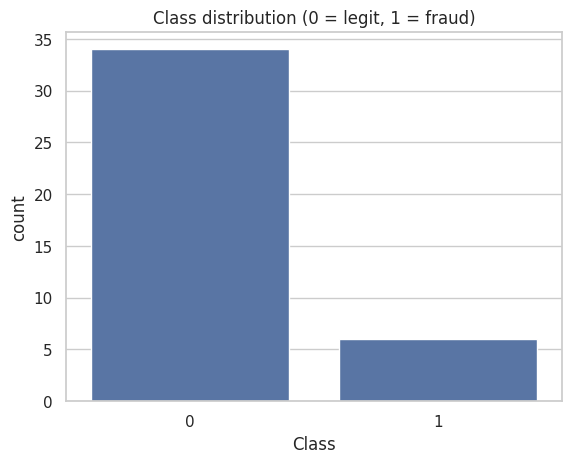

In [5]:
# Cell 3: Load dataset
df = pd.read_csv("/content/creditcard_indian_human_friendly.csv")# update if needed


print("Shape:", df.shape)
display(df.head())
display(df.info())
display(df.describe().T)

# Check class distribution
print("\nClass distribution:")
print(df['Class'].value_counts())
sns.countplot(x='Class', data=df)
plt.title("Class distribution (0 = legit, 1 = fraud)")
plt.show()


In [8]:
# Cell 4: Simple preprocessing: handle missing values and encode categoricals
print("Missing values per column:\n", df.isnull().sum())

# Separate target
TARGET = 'Class'
if TARGET not in df.columns:
    raise ValueError("Target column 'Class' not found in dataset.")

X = df.drop(columns=[TARGET])
y = df[TARGET]

# Identify categorical columns (object or category dtype)
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", cat_cols)

# One-hot encode categoricals
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

print("After encoding - Features:", X.shape[1])


Missing values per column:
 Time                0
CardType            0
MerchantCategory    0
TransactionMode     0
State               0
IsInternational     0
DayOfWeek           0
Amount              0
Class               0
dtype: int64
Categorical columns: ['CardType', 'MerchantCategory', 'TransactionMode', 'State', 'DayOfWeek']
After encoding - Features: 23


In [9]:
# Cell 5: Train-test split and scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Standard scaling (fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for future use
import joblib
joblib.dump(scaler, "scaler.joblib")


Train shape: (32, 23) Test shape: (8, 23)


['scaler.joblib']

Fraud samples in training set: 5
Using k_neighbors = 4 for SMOTE
After SMOTE - class distribution:
 Class
0    27
1    27
Name: count, dtype: int64


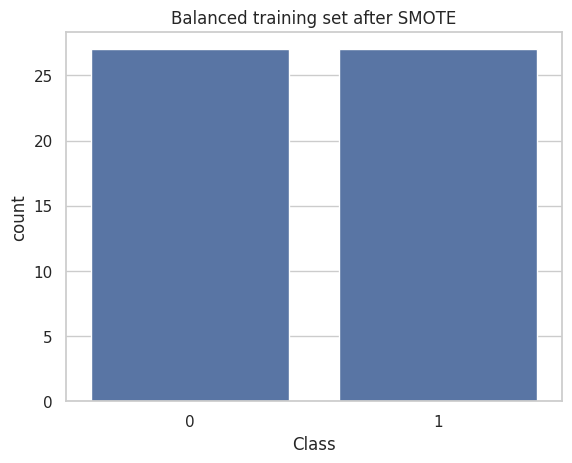

In [13]:
# Cell 6: Apply SMOTE to training data only (do NOT touch test set)
from imblearn.over_sampling import SMOTE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Check fraud samples in training
fraud_count = y_train.sum()
print(f"Fraud samples in training set: {fraud_count}")

# Adjust k_neighbors for small dataset
k_neighbors_value = min(5, int(fraud_count) - 1) if fraud_count > 1 else 1
print(f"Using k_neighbors = {k_neighbors_value} for SMOTE")

# Apply SMOTE (no n_jobs here)
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=k_neighbors_value)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

print("After SMOTE - class distribution:\n", pd.Series(y_train_bal).value_counts())

# Plot distribution
sns.countplot(x=y_train_bal)
plt.title("Balanced training set after SMOTE")
plt.show()


In [15]:
# Cell 7 - ROC Curve Plotting

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_scores, label=None):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{label} - ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)

# Example usage:
# plot_roc_curve(y_test, model.predict_proba(X_test)[:, 1], label="Logistic Regression")
# plt.show()


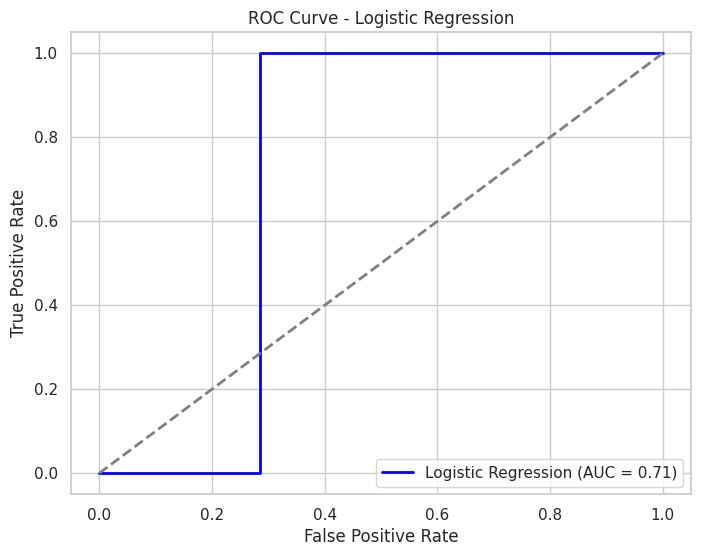

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1️⃣ Create & Train the Model
model = LogisticRegression()
model.fit(X_train, y_train)

# 2️⃣ Predict Probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Positive class probability

# 3️⃣ Function to Plot ROC Curve
def plot_roc_curve(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# 4️⃣ Plot ROC for Logistic Regression
plot_roc_curve(y_test, y_pred_proba, "Logistic Regression")


In [19]:
# 📌 Cell 9 - Train the Logistic Regression model
from sklearn.linear_model import LogisticRegression

# Create and train the model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

print("✅ Model trained successfully")


✅ Model trained successfully


In [20]:
# 📌 Cell 10 - Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

# Predictions
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.7500

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.00      0.00      0.00         1

    accuracy                           0.75         8
   macro avg       0.43      0.43      0.43         8
weighted avg       0.75      0.75      0.75         8



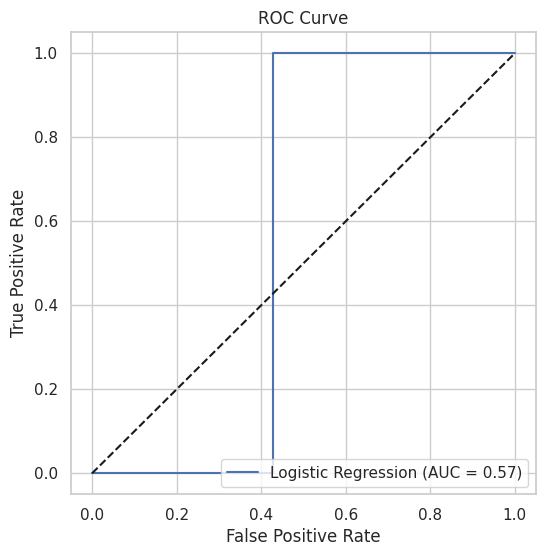

In [21]:
# 📌 Cell 11 - ROC Curve Plot
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# ✅ FIX: generate prediction probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

plot_roc_curve(y_test, y_pred_proba, "Logistic Regression")
